In [ ]:
import os
import pandas as pd
import numpy as np
import urllib.request
import PIL.Image
import matplotlib.pyplot as plt
import kagglehub
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

In [3]:
## Downloading latest version of the data and assigning to a dataframe ##
path = kagglehub.dataset_download("ioexception/yugioh-cards")
df = pd.read_csv(os.path.join(path, "cards.csv"))


100%|██████████| 1.93M/1.93M [00:00<00:00, 3.45MB/s]

Extracting files...


In [14]:
df["ocg_date"] = pd.to_datetime(df["ocg_date"], format="%Y-%m-%d", errors="coerce")
df["year"] = df["ocg_date"].dt.year
df["year"] = df["year"].astype("Int64")
df = df.dropna(subset=["year"])
df["type"] = df["type"].apply(lambda x: "Monster" if x.endswith("Monster") else x) # Groups all monster types together
df = df[~df["type"].isin(["Skill Card"])] # Removes the "Skill Card" type 

In [24]:
# Filtering DataFrame to include only cards related to special summoning 
special_summon_text = [
    "Special Summon this card",
    "Special Summon 1",
    "Special Summon them",
    "Special Summon a",
    "Fusion Summon 1",
    "Ritual Summon 1",
    "Xyz Summon 1",
    "Link Summon 1"
]

special_summon_df = df[df["desc"].str.contains("|".join(special_summon_text))]
special_summon_df["ocg_date"] = pd.to_datetime(special_summon_df["ocg_date"], format="%Y-%m-%d", errors="coerce")
special_summon_df["year"] = special_summon_df["ocg_date"].dt.year
special_summon_df["year"] = special_summon_df["year"].astype("Int64")
special_summon_df = special_summon_df.dropna(subset=["year"])
special_summon_df["type"] = special_summon_df["type"].apply(lambda x: "Monster" if x.endswith("Monster") else x) # Groups all monster types together
special_summon_df = special_summon_df[~special_summon_df["type"].isin(["Skill Card"])] # Removes the "Skill Card" type 

/tmp/ipykernel_1691/129700483.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  special_summon_df["ocg_date"] = pd.to_datetime(special_summon_df["ocg_date"], format="%Y-%m-%d", errors="coerce")
/tmp/ipykernel_1691/129700483.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  special_summon_df["year"] = special_summon_df["ocg_date"].dt.year
/tmp/ipykernel_1691/129700483.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

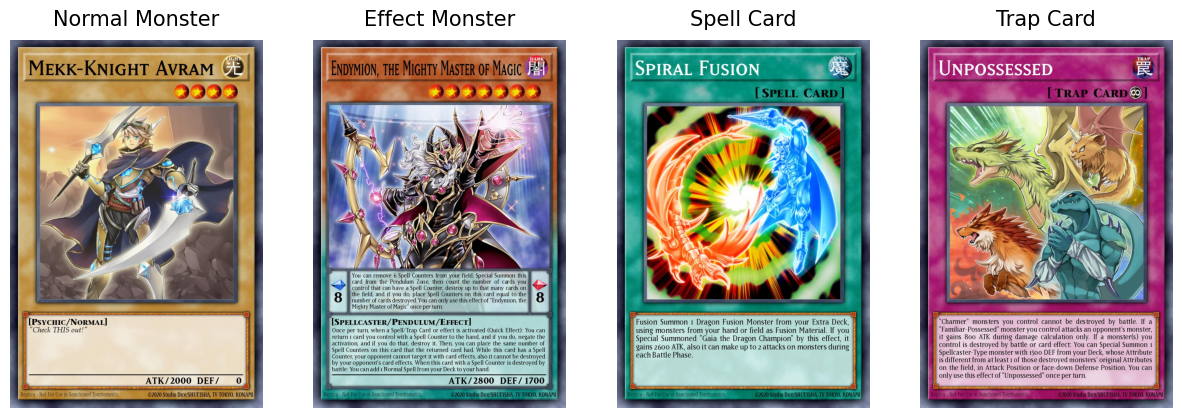

In [ ]:
## Plotting 4 cards ##

# Load images
target_names = ["Mekk-Knight Avram", "Endymion, the Mighty Master of Magic", "Spiral Fusion", "Unpossessed"]
urls = df.loc[df["name"].isin(target_names), "image_url"].tolist()
images = [np.array(PIL.Image.open(urllib.request.urlopen(url))) for url in urls]

# Creating plot
fig, ax = plt.subplots(1, 4, figsize=(15, 30))
ax[0].imshow(images[1])
ax[1].imshow(images[0])
ax[2].imshow(images[2])
ax[3].imshow(images[3])
ax[0].set_title("Normal Monster", fontsize=15, pad=10)
ax[1].set_title("Effect Monster", fontsize=15, pad=10)
ax[2].set_title("Spell Card", fontsize=15, pad=10)
ax[3].set_title("Trap Card", fontsize=15, pad=10)
for a in ax:
    a.axis("off")


In [ ]:
## Plotting text dispersion over time ##

def plot_text_dispersion_scatter(df, title):
    """
    Generates and saves a scatter plot showing the dispersion of text-based embeddings over time.

    Args:
        df (pd.DataFrame): DataFrame containing 'desc' (text descriptions), 'name' (card names),
                           'type' (card types), and 'year' (card years).
        title (str): Title for the plot.

    Returns:
        None: .

    The function encodes text descriptions into embeddings using a SentenceTransformer model, 
    reduces the embeddings to 2D with PCA, calculates centroids per year and card type, computes 
    dispersion using Euclidean distance, and visualizes results in a scatter plot with regression 
    trend lines for each card type.
    """
    output_dir = "out"
    
    # Loading sentence-transformer model
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

    # Encoding card text into embeddings
    embeddings = model.encode(df["desc"].tolist())

    # Reducing embeddings to 2D for easier visualization
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Converting to DataFrame for analysis
    embed_df = pd.DataFrame(reduced_embeddings, columns=["Dim1", "Dim2"])
    embed_df["year"] = pd.to_numeric(df["year"], errors="coerce") 
    embed_df["type"] = df["type"]

    # Removing potential NaN values before processing
    embed_df.dropna(subset=["year"], inplace=True)

    # Calculating centroid (mean position) per year & card type
    centroids = embed_df.groupby(["year", "type"])[["Dim1", "Dim2"]].mean().reset_index()

    # Computing euclidean distances from centroid to measure dispersion
    embed_df = embed_df.merge(centroids, on=["year", "type"], suffixes=("", "_centroid"))
    embed_df["distance"] = np.sqrt((embed_df["Dim1"] - embed_df["Dim1_centroid"])**2 + 
                                   (embed_df["Dim2"] - embed_df["Dim2_centroid"])**2)

    # Defining color mapping for card types
    color_map = {
        "Spell Card": "green",
        "Trap Card": "purple",
        "Monster": "orange",
        "Normal Monster": "blue"
    }

    # Applying color palette manually
    sns.set_palette([color_map.get(card_type, "black") for card_type in df["type"].unique()])

    # Creating scatter plot with correct colors
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x="year", y="distance", hue="type", data=embed_df, alpha=0.7)

    # Computing and adding regression lines manually
    for card_type, color in color_map.items():
        subset = embed_df[embed_df["type"] == card_type]
        if len(subset) > 1:  # Ensure enough points for regression
            coef, intercept = np.polyfit(subset["year"], subset["distance"], 1)  # Linear fit
            x_vals = np.linspace(subset["year"].min(), subset["year"].max(), 100)
            y_vals = coef * x_vals + intercept
            y_vals_pred = coef * subset["year"] + intercept

            # Computing R² score manually
            ss_total = np.sum((subset["distance"] - np.mean(subset["distance"]))**2)
            ss_residual = np.sum((subset["distance"] - y_vals_pred)**2)
            r2_score = 1 - (ss_residual / ss_total)

            plt.plot(x_vals, y_vals, color=color, linestyle="dashed", label=f"{card_type} Trend (Coef: {round(coef, 4)}, R²: {round(r2_score, 4)})")

            print(f"Regression for {card_type}: Distance = {round(coef, 4)} * Year + {round(intercept, 4)}")

    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Dispersion (Distance from Centroid)")
    plt.xticks(rotation=45)
    plt.legend(title="Card Type")

Regression for Spell Card: Distance = 0.0015 * Year + -2.9507
Regression for Trap Card: Distance = 0.0017 * Year + -3.2649
Regression for Monster: Distance = 0.0003 * Year + -0.4806


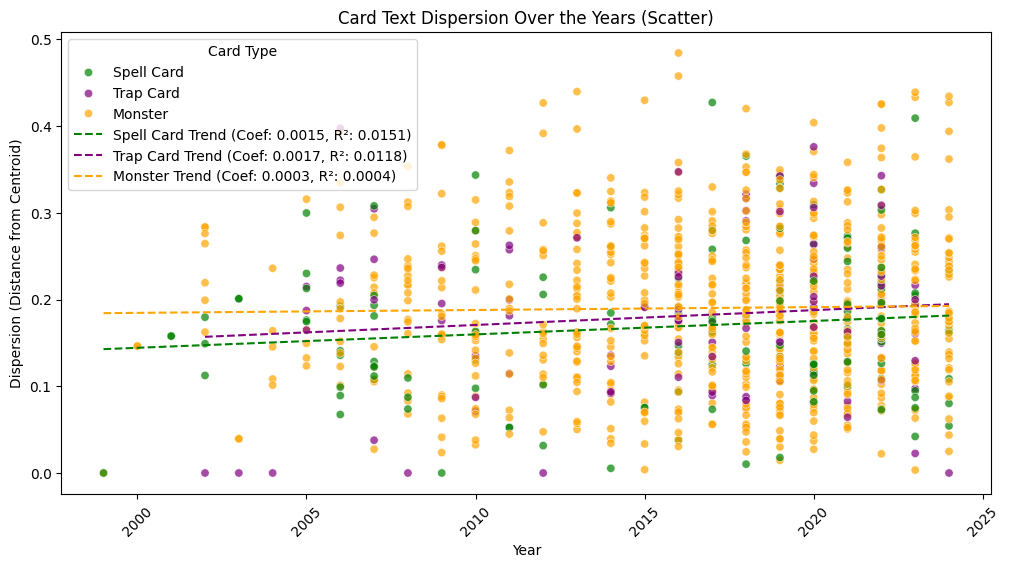

In [25]:
## Text Dispersion ##
plot_text_dispersion_scatter(special_summon_df, "Card Text Dispersion Over the Years (Scatter)")